In [127]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [128]:
# Load data into a data frame

df = pd.read_csv('weatherAUS.csv')

In [129]:
# Let's check the dataset size

df.shape


(145460, 23)

 We have missing values, NaNs, but we need to do something about this, therefore we proceed to
 
 Data Preprocessing 

In [130]:
# We will simplify the problem by removing most of the data and we will keep only 4 columns
# to predict whether or not is goint to rain tomorrow

cols=["Rainfall", "Humidity3pm", "Pressure9am", "RainToday", "RainTomorrow"]

df=df[cols]



In [131]:
# Neural Nets will work with numbers mainly, we will convert yes and no into 1 and 0.

df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)

df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)


In [132]:
# Let's drop the rows with missing values

df = df.dropna(how='any')

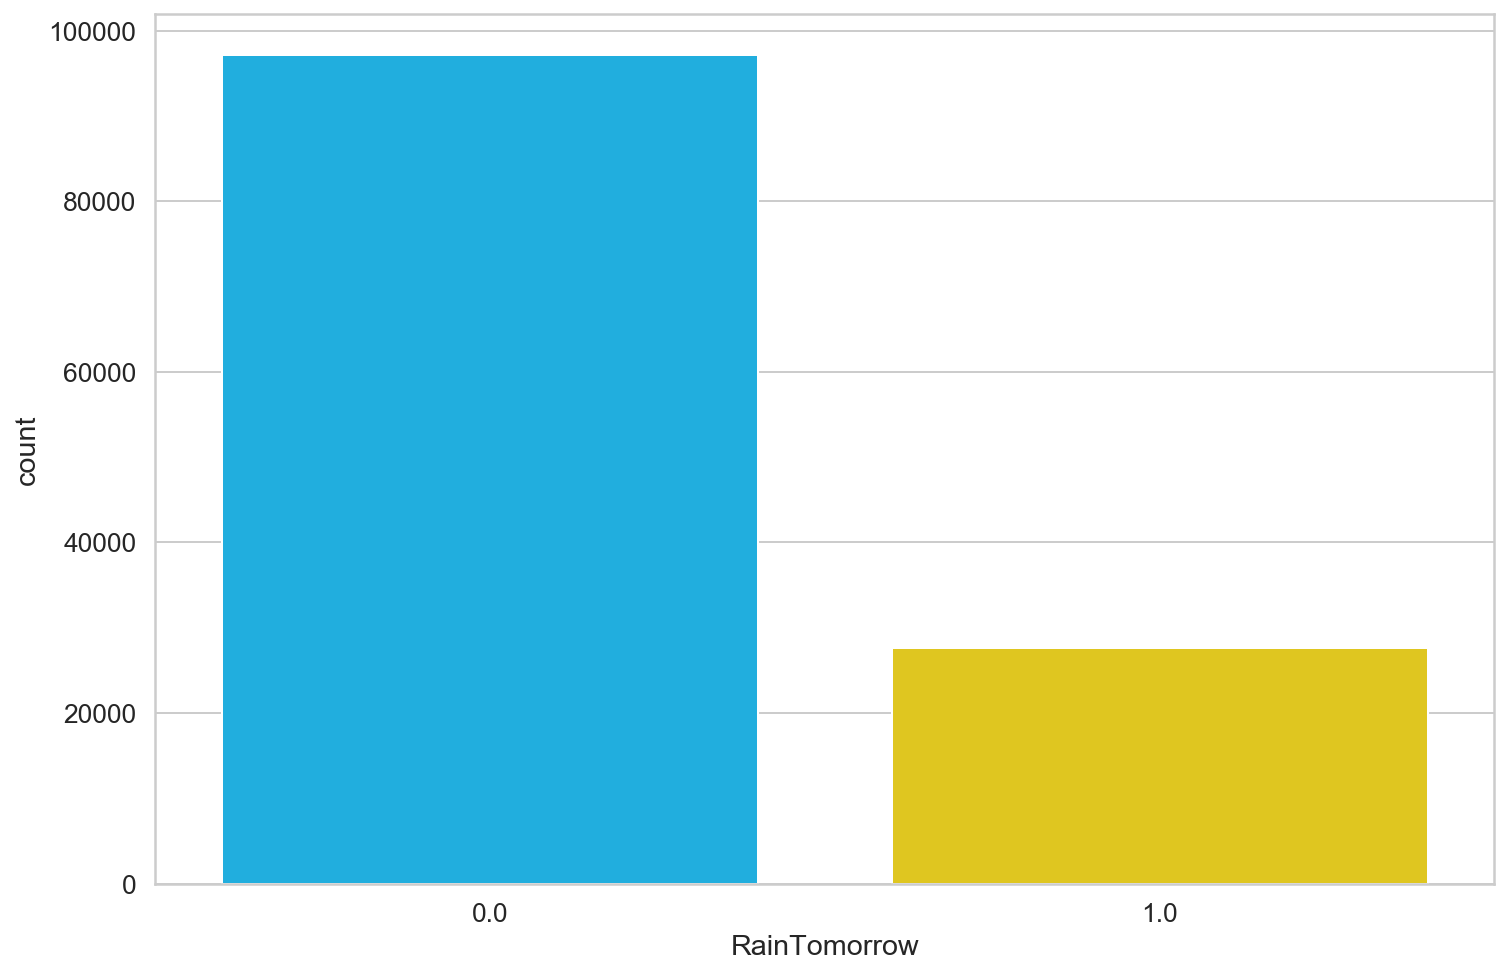

In [133]:
# Now we can work with the dataset but how balanced is our dataset? How many times did it rain or did not rain tomorrow?


sns.countplot(df.RainTomorrow);

In [134]:
df.RainTomorrow.value_counts()/df.shape[0]

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

Our dataset looks imbalanced because a model that predicts there will be no rain tomorrow 
will be correct about 78% of the time.

In [135]:
# The final step is to split the data into train and test sets

X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [136]:
# Let's convert it to Tensors so we can use it with Pytorch

X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


# # Building the first Neural Network 


In [137]:
# The Neural Net will try to predict if it's going to rain tomorrow 
# The input data contains data from the 4 columns 'Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am'
# and we will create an input layer for this

# The output will be a number between 0 and 1, representing how likely (our model thinks) it is going to rain tomorrow.
# The prediction will be given to us by the final (output) layer of the network.

# We’ll add two (hidden) layers between the input and output layers.
# The parameters (neurons) of those layer will decide the final output. All layers will be fully-connected.

# One easy way to build the NN with PyTorch is to create a class that inherits from torch.nn.Module

class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return torch.sigmoid(self.fc3(x))
net = Net(X_train.shape[1])
                          
        

In [138]:
# The forward() method is where the magic happens. 
# It accepts the input x and allows it to flow through each layer.

# There is a corresponding backward pass, defined by PyTorch
# that allows the model to learn from the errors that is currently making.


                     

# ACTIVATION FUNCTIONS:

In [139]:


# ReLU
# Not at all, let start with the ReLU definition (one of the most widely used activation function):

    
# ReLU(x)=max(0,x)
# Easy peasy, the result is the maximum value of zero and the input
                      
                      

        
# Sigmoid
# The sigmoid is useful when you need to make a binary decision/classification (answering with a yes or a no).

 
# The sigmoid squishes the input values between 0 and 1. But in a super kind of way

# Training 



In [140]:
# With the model in place, we need to find parameters that predict will it rain tomorrow.
# First, we need something to tell us how good we’re currently doing

criterion = nn.BCELoss()

In [141]:
# The BCELoss is a loss function that measures the difference between two binary vectors. 
# In our case, the predictions of our model and the real values. 
# It expects the values to be outputed by the sigmoid function. 
# The closer this value gets to 0, the better your model should be.

# But how do we find parameters that minimize the loss function?

# Optimization

In [142]:
# Imagine that each parameter of our NN is a knob. 
# The optimizer’s job is to find the perfect positions for each knob so that the loss gets close to 0.
# While there are tons of optimizers you can choose from, Adam is a safe first choice.
# PyTorch has a well-debugged implementation you can use:

optimizer = optim.Adam(net.parameters(), lr=0.1)

In [143]:
# Naturally, the optimizer requires the parameters. The second argument lr is learning rate. 
# It is a tradeoff between how good parameters you’re going to find and how fast you’ll get there. 
# Finding good values for this can be black magic and a lot of brute-force “experimentation”.

# The accuracy of the model- in our case Weather Forecasting

In [144]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

# We convert every value below 0.5 to 0. Otherwise, we set it to 1. 
# Finally, we calculate the percentage of correct values.

# Training the model

In [149]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)
for epoch in range(0,1000,100):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 100
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 200
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 300
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 400
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 500
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 600
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 700
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 800
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222

epoch 900
Train set - loss: 77.884, accuracy: 0.221
Test  set - loss: 77.845, accuracy: 0.222



In [ ]:
# The loss is too high 

In [150]:
# Saving the model

MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

In [151]:
net = torch.load(MODEL_PATH) # restoring the model

# Evaluating the model

In [152]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()

y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     No rain       0.00      0.00      0.00     19413
     Raining       0.22      1.00      0.36      5525

    accuracy                           0.22     24938
   macro avg       0.11      0.50      0.18     24938
weighted avg       0.05      0.22      0.08     24938



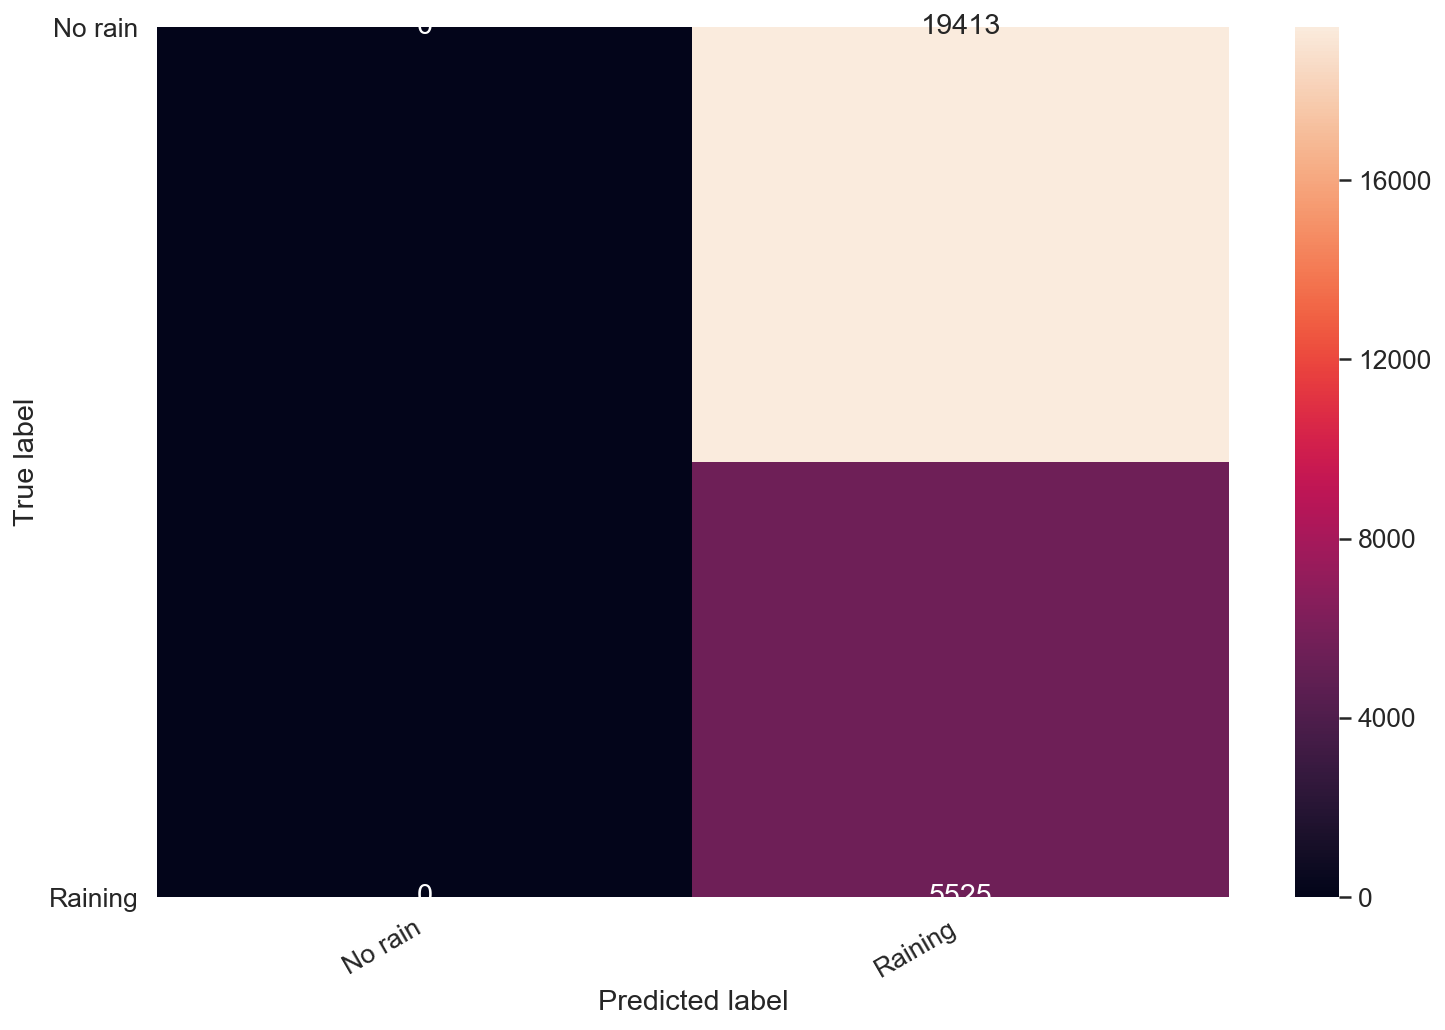

In [153]:
# Confusion Matrix


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
# You can clearly see that our model shouldn’t be trusted when it says it’s going to rain.

In [164]:
# Making Predictions

def will_it_rain(rainfall, humidity, rain_today, pressure):
  t = torch.as_tensor([rainfall, humidity, rain_today, pressure]) \
      .float() \
      .to(device)
  output = net(t)
  return output.ge(0.5).item()

NameError: name 'device' is not defined